<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Stocks_Tickers_Correlation_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [3]:
#!pip install yfinance
import yfinance as yf

import numpy as np
import pandas as pd

import scipy
import scipy.cluster.hierarchy as sch

import statsmodels
from statsmodels.tsa.stattools import coint
# set the seed for the random number generator
np.random.seed(42)

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Read S&P 500 Stock Data from Wikipedia

In [58]:
# Read S&P 500 Stock Data from Wikipedia
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
data = table[0]
data

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [59]:
# Count of Stocks per Sector
data['GICS Sector'].value_counts()

Information Technology    75
Industrials               71
Financials                67
Health Care               64
Consumer Discretionary    56
Consumer Staples          33
Real Estate               31
Utilities                 30
Materials                 28
Communication Services    25
Energy                    23
Name: GICS Sector, dtype: int64

In [60]:
# Create a list of S&P 500 tickers
SPY_list = data.Symbol.unique().tolist()
len(SPY_list)

503

In [61]:
# Create a list of XLE tickers
XLE_list = data[data['GICS Sector'] == 'Energy'].Symbol.unique().tolist()
len(XLE_list)

23

## Download Data from Stocks Tickers

In [62]:
# Multiple Tickers Data
TickersData = yf.download(
        # tickers list or string as well
        tickers = XLE_list,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = False,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data = TickersData['Close']
print(len(data))
data.tail()

[*********************100%***********************]  23 of 23 completed
253


,APA,BKR,COP,CTRA,CVX,DVN,EOG,EQT,FANG,HAL,...,MRO,OKE,OXY,PSX,PXD,SLB,TRGP,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-22,47.779999,29.490000,129.979996,27.500000,185.889999,68.570000,144.320007,43.779999,151.440002,37.450001,...,31.190001,65.419998,72.769997,112.290001,251.080002,53.639999,74.029999,141.979996,34.209999,114.180000
2022-11-23,46.779999,28.830000,126.739998,27.540001,184.240005,67.800003,142.649994,43.560001,149.990005,36.560001,...,30.650000,65.620003,71.120003,110.709999,254.369995,51.419998,73.389999,139.210007,33.830002,113.610001
2022-11-25,46.430000,28.500000,126.809998,27.610001,183.699997,68.349998,142.639999,43.029999,149.320007,36.360001,...,30.379999,65.419998,70.279999,110.779999,254.139999,50.830002,73.309998,138.399994,33.900002,113.209999
2022-11-28,44.959999,28.190001,123.839996,27.150000,178.360001,66.529999,136.649994,41.520000,143.729996,35.880001,...,29.809999,63.720001,68.230003,107.820000,245.210007,49.880001,72.290001,134.839996,33.480000,109.809998
2022-11-29,46.250000,28.520000,124.220001,27.822201,180.169998,66.885002,139.320007,41.880001,145.763596,37.075001,...,30.115000,64.565002,68.820000,108.760002,240.550003,51.044998,73.040001,135.505005,34.154999,110.050003


In [63]:
# Check for Empty/NA cells
data.isnull().any().value_counts()

False    23
dtype: int64

In [64]:
# Drop columns with Empty/NA cells
data = data.dropna(axis=1)
print(data.shape)

(253, 23)


## Check the Pearson Correlations.

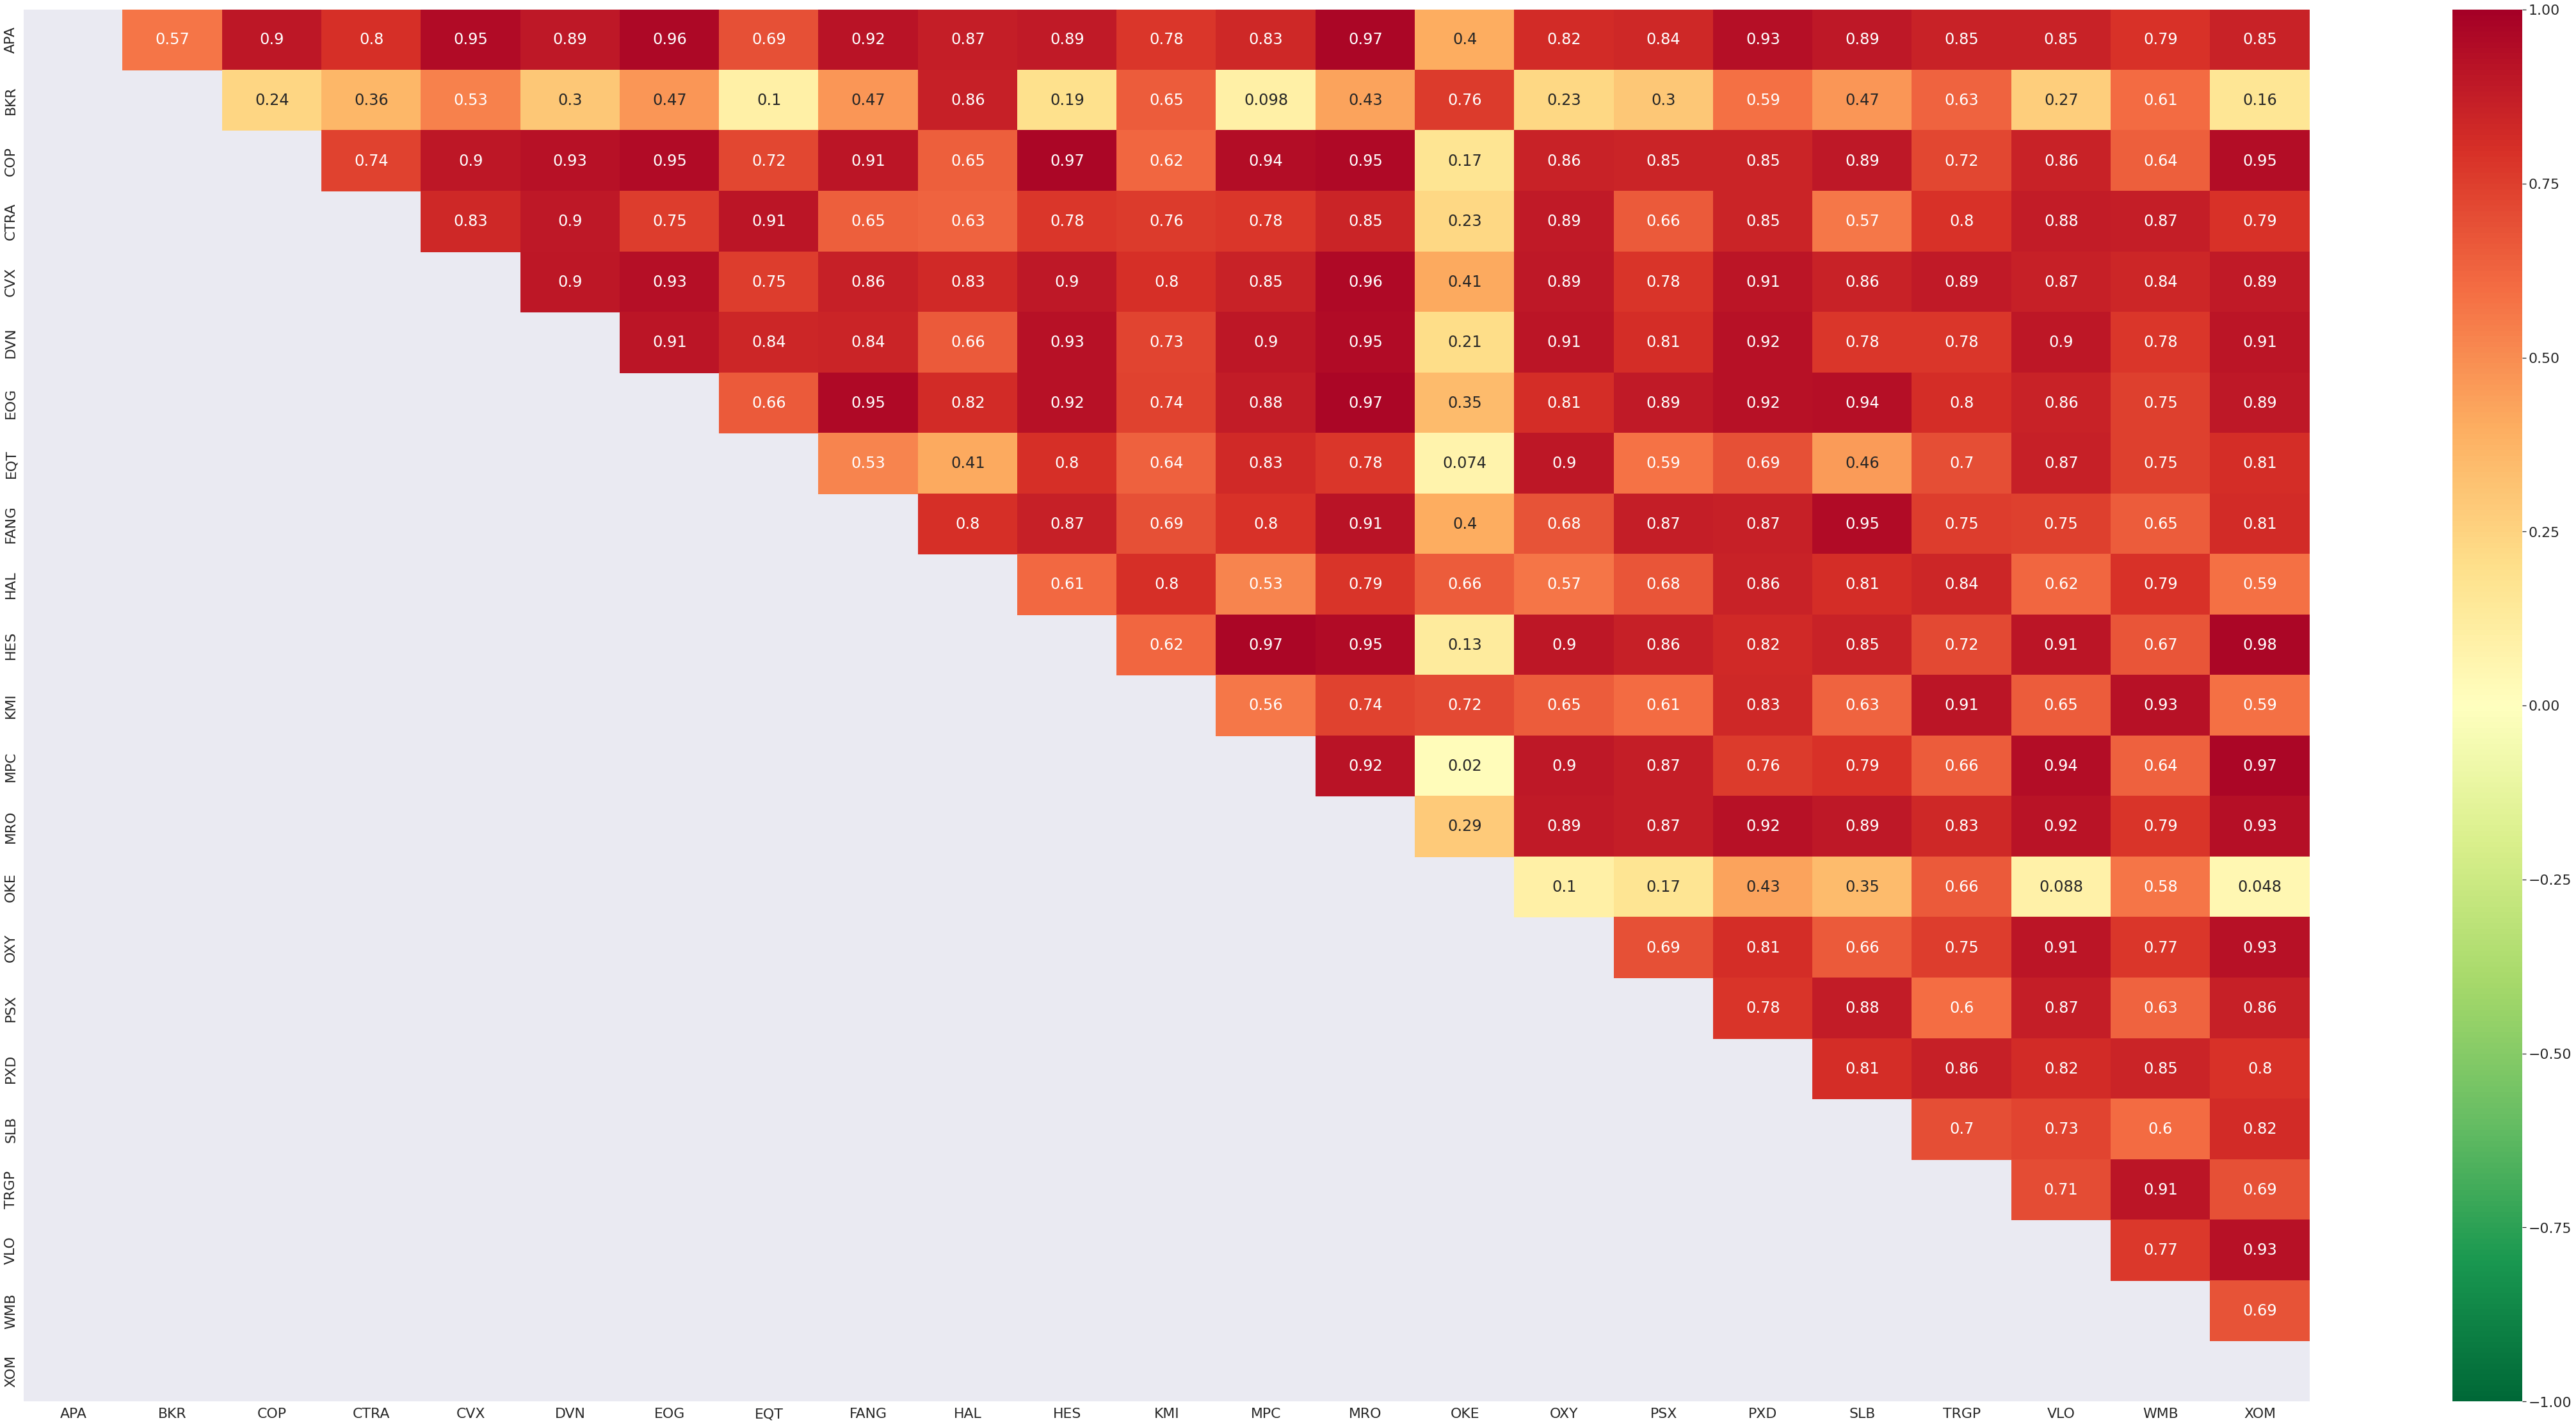

In [84]:
lower = np.tril(data.corr())
fig, ax = plt.subplots(figsize=(80, 40))
sns.set(font_scale=2)
sns.heatmap(data.corr(), vmin =-1, vmax =+1, annot=True, cmap='RdYlGn_r',mask=lower)


In [80]:
# Cluster Correlations function (Thanks to @wyegelwel)

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

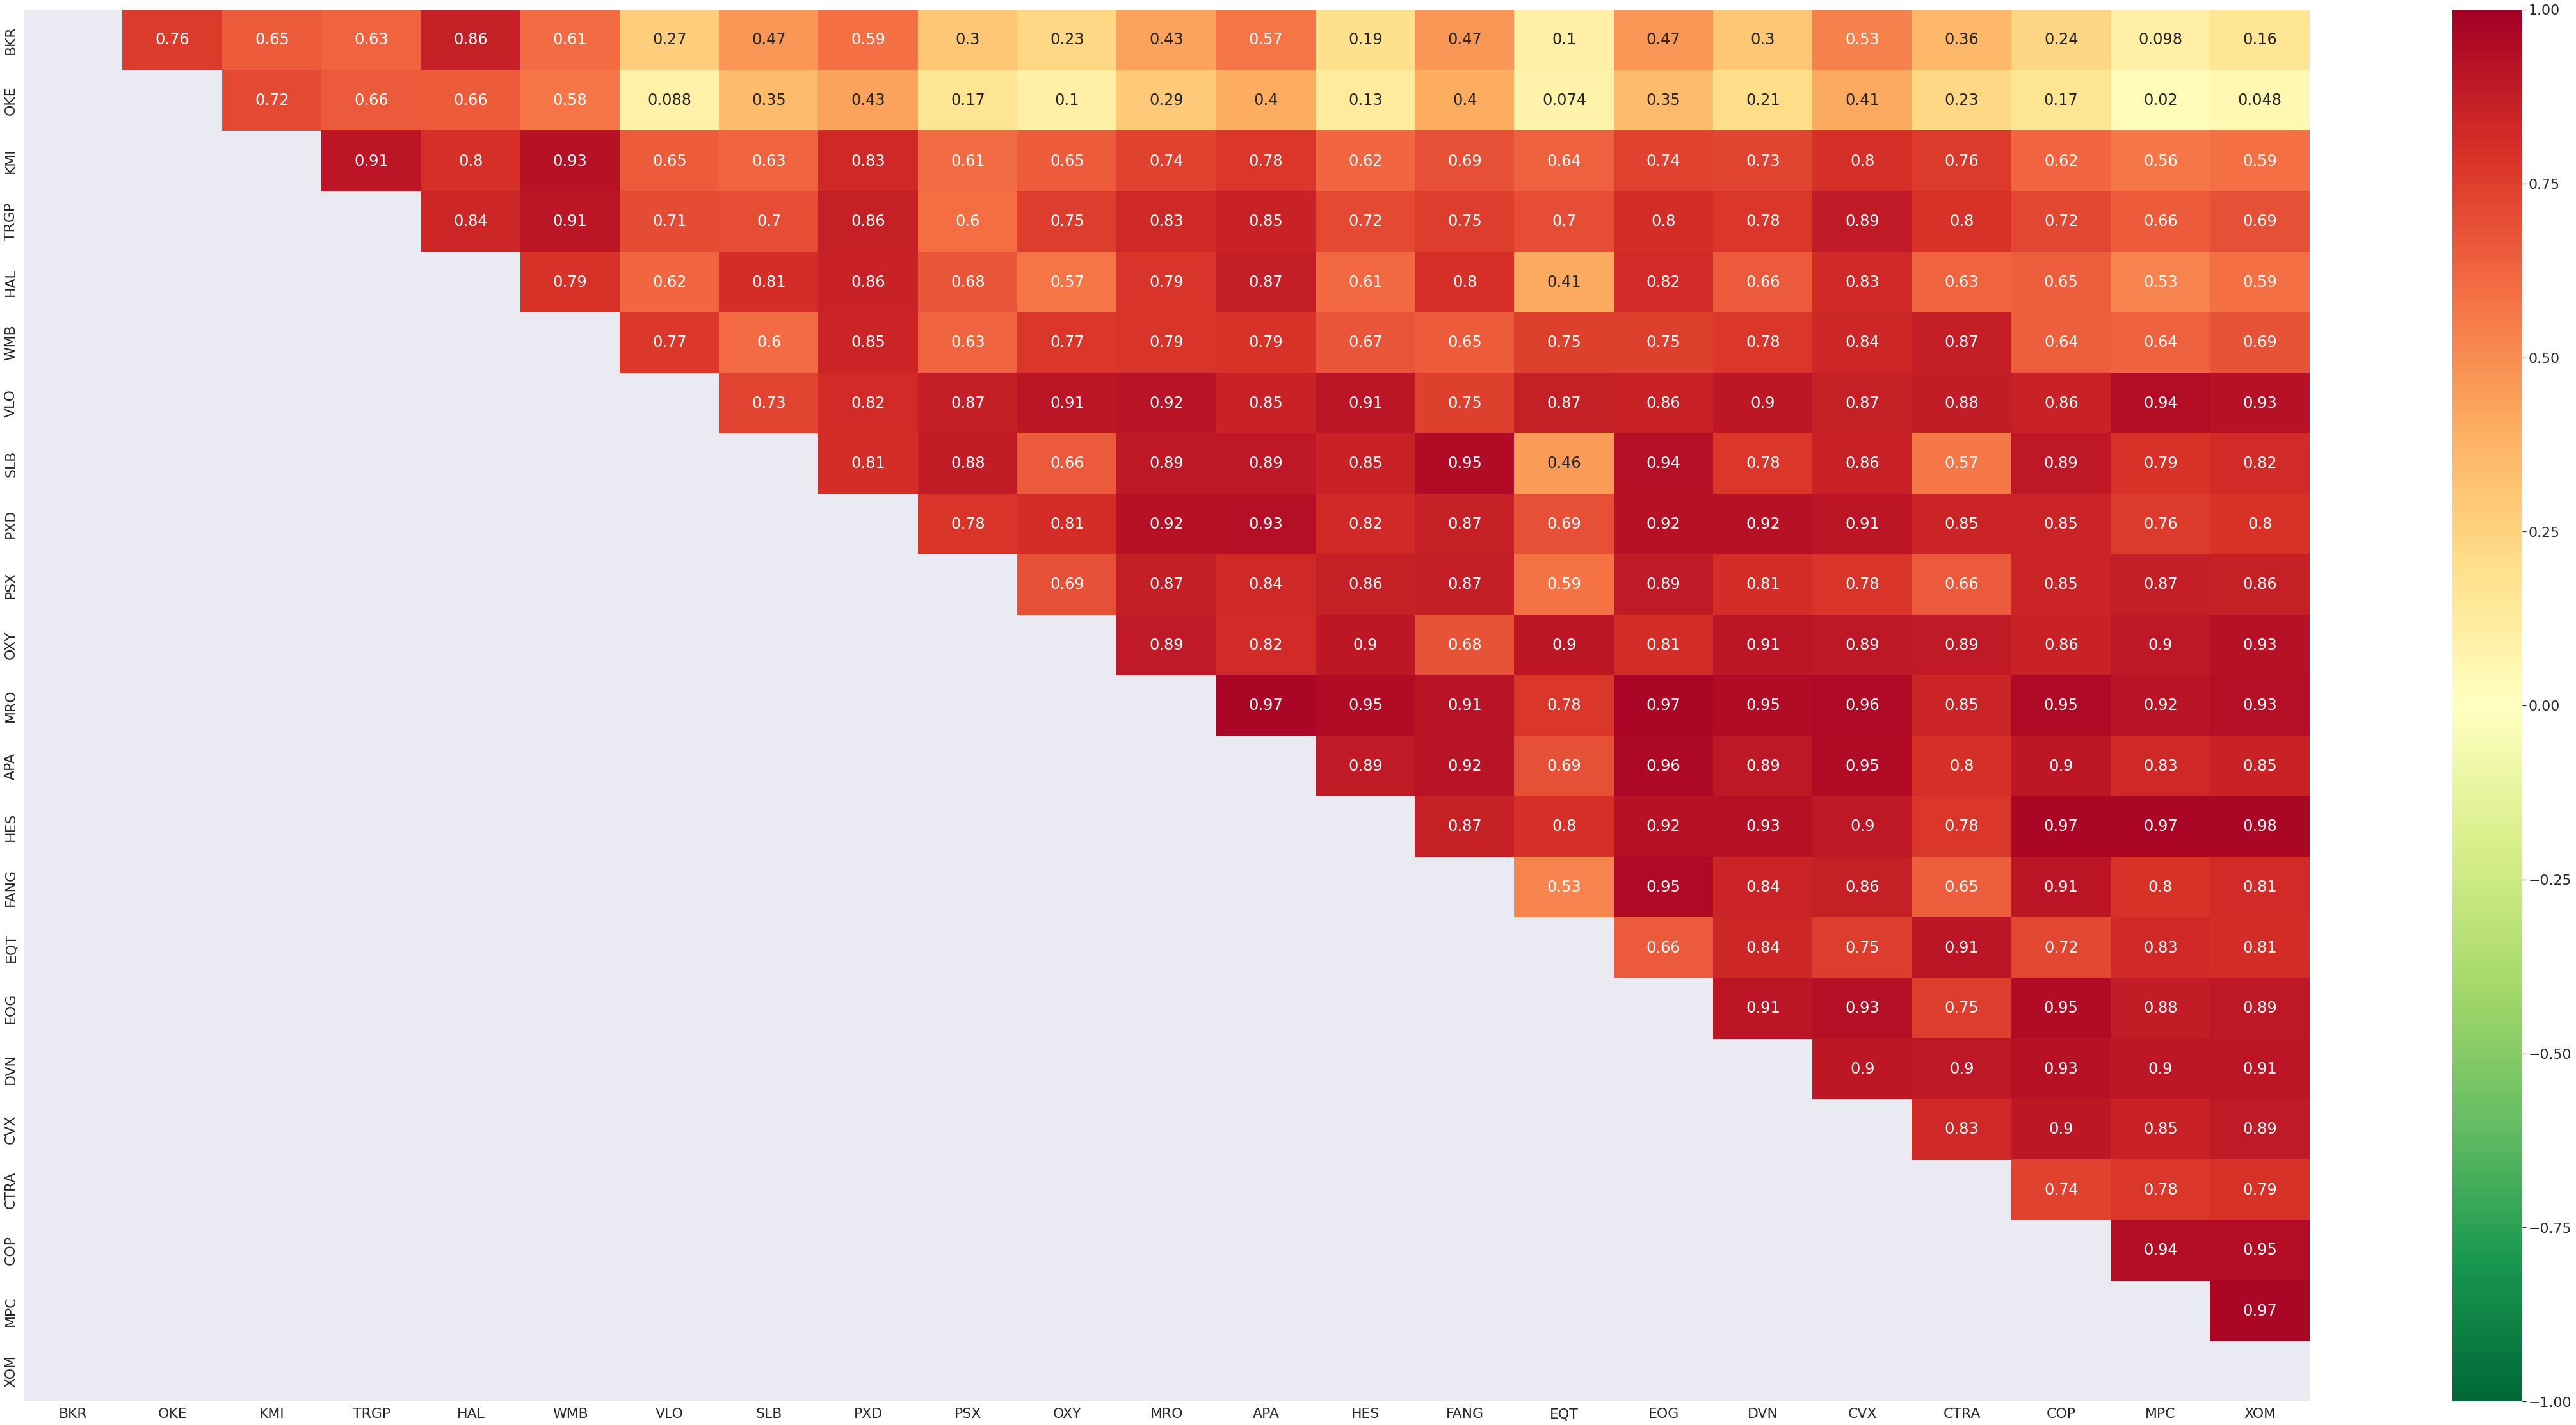

In [85]:
fig, ax = plt.subplots(figsize=(80, 40))
sns.heatmap(cluster_corr(data.corr()), vmin =-1, vmax =+1, annot=True, cmap='RdYlGn_r',mask=lower) # Clustered version

## Normalized Distance Matrix

In [86]:
# Create a Stacked and Normalized (0-100) Correlation Matrix
corr_matrix = data.corr().replace(1,np.nan).stack(dropna=True)
corr_matrix = (corr_matrix*-50)+50
corr_matrix = corr_matrix.to_frame(name='Distance').reset_index()
corr_matrix = corr_matrix.rename( columns={'level_0': 'Origin', 'level_1': 'Destination'} )
corr_matrix.head()

,Origin,Destination,Distance
0,APA,BKR,21.380889
1,APA,COP,4.943434
2,APA,CTRA,9.801004
3,APA,CVX,2.571581
4,APA,DVN,5.336337


In [ ]:
# Export Distance Matrix to CSV File
corr_matrix.to_csv('CorrelationMatrix.csv')